# Meme/Number/Face Generation using a G.A.N.
Using AWS EC2 instance, AWS S3 Buckets, and Tensorflow open source python library

## Overview
Using Tensorflow open source python library to create a Generative Adversarial Network that is trained on three datasets: one for numbers, another for faces, and one for memes.

A Generative Adversarial network is a combination of two neural networks, a discriminator and a generator. The generator is fed an array of random numbers as input and returns an image. The discriminator takes in this generated image as input as well as images taken from the real dataset and returns a prediction as to whether the image was from the dataset (real) or generate (fake), and both neural networks are updated and trained using a loss function to produce intended results. 

### Dowloading Data

In [1]:
data_dir = './data'

import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)
# For the meme dataset, I compiled a 18,780 image long directory on my personal computer.

Found mnist Data
Found celeba Data


### MNIST Dataset

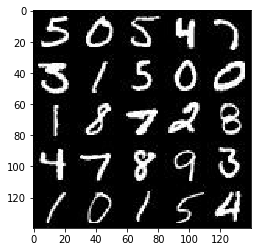

In [2]:
show_n_images = 25

%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
from PIL import Image

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### Memes Dataset of 18,780 Memes

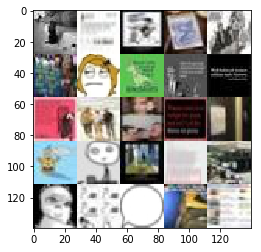

In [3]:
show_n_images = 25

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'memes/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

### CelebA Dataset of Celebrity Faces

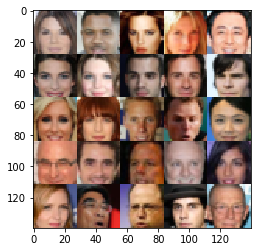

In [4]:
show_n_images = 25

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

In [5]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input of Randomly Generated Numbers to the Generator

In [6]:

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    z_data = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, (None), name="learning_rate")
    return real_input_images, z_data, learning_rate

print("Success")

Success


### Discriminator

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.conv2d(images, 28, 4, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        
        x = tf.layers.conv2d(images, 128, 4, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        
        x = tf.layers.conv2d(images, 256, 4, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        
        flat = tf.reshape(x, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
    return output, logits


print("Success")

Success


### Generator

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        x = tf.layers.dense(z, 4*4*512)
        
        x = tf.reshape(x, (-1, 4,4,512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        
        x = tf.layers.conv2d_transpose(x, 256, 4, strides=1, padding='valid')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        
        x = tf.layers.conv2d_transpose(x, 128, 4, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        
        #x = tf.nn.dropout(x, keep_prob=0.95)
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
    return out


print("Success")

Success


### Loss

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    alpha=0.9
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*alpha))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


print("Success")

Success


### Optimization

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt

print("Success")

Success


## Neural Network Training
### Shows Output
Shows GAN Training Output

In [11]:

import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):

# TODO: Build Model
    
    #out_channel_dim = 3 if data_image_mode=="RGB" else 1    
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
        # TODO: Train Model
                steps+=1
                batch_images = batch_images*2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
            
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z, lr: learning_rate, input_real: batch_images})
            
                if steps % 100 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g),
                          "Step: {:.4f}".format(steps))
                if steps % 200 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST

Epoch 1/2... Discriminator Loss: 1.4134... Generator Loss: 1.4771 Step: 100.0000
Epoch 1/2... Discriminator Loss: 1.6145... Generator Loss: 1.5829 Step: 200.0000


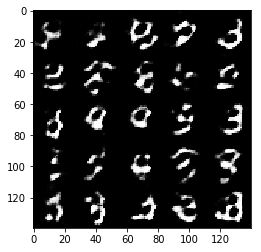

Epoch 1/2... Discriminator Loss: 1.5021... Generator Loss: 1.0172 Step: 300.0000
Epoch 1/2... Discriminator Loss: 1.5216... Generator Loss: 1.2801 Step: 400.0000


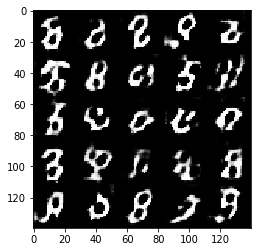

Epoch 1/2... Discriminator Loss: 1.3247... Generator Loss: 0.8060 Step: 500.0000
Epoch 1/2... Discriminator Loss: 1.3061... Generator Loss: 0.7789 Step: 600.0000


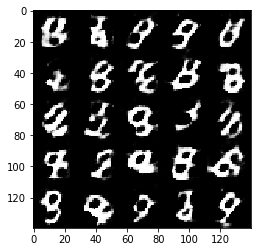

Epoch 1/2... Discriminator Loss: 1.3810... Generator Loss: 0.9478 Step: 700.0000
Epoch 1/2... Discriminator Loss: 1.3677... Generator Loss: 0.6997 Step: 800.0000


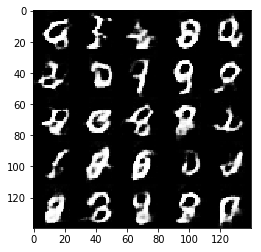

Epoch 1/2... Discriminator Loss: 1.3225... Generator Loss: 0.9608 Step: 900.0000
Epoch 1/2... Discriminator Loss: 1.3561... Generator Loss: 0.9977 Step: 1000.0000


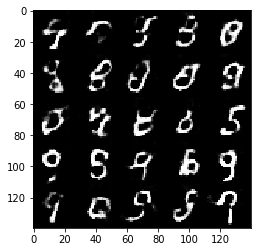

Epoch 1/2... Discriminator Loss: 1.4000... Generator Loss: 0.9563 Step: 1100.0000
Epoch 1/2... Discriminator Loss: 1.3171... Generator Loss: 0.7531 Step: 1200.0000


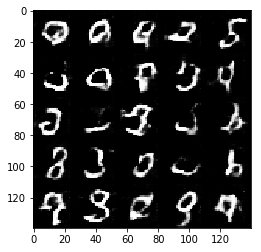

Epoch 2/2... Discriminator Loss: 1.3402... Generator Loss: 0.8980 Step: 1300.0000
Epoch 2/2... Discriminator Loss: 1.4615... Generator Loss: 1.2458 Step: 1400.0000


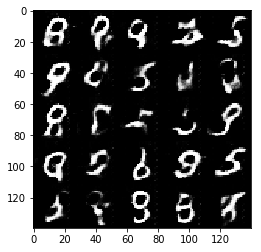

Epoch 2/2... Discriminator Loss: 1.3194... Generator Loss: 1.0594 Step: 1500.0000
Epoch 2/2... Discriminator Loss: 1.3783... Generator Loss: 0.7252 Step: 1600.0000


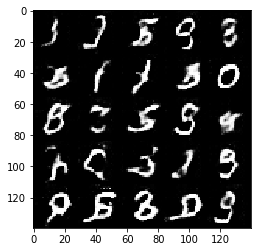

Epoch 2/2... Discriminator Loss: 1.3917... Generator Loss: 1.0472 Step: 1700.0000
Epoch 2/2... Discriminator Loss: 1.3579... Generator Loss: 0.8473 Step: 1800.0000


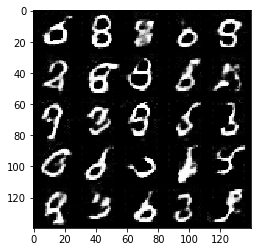

Epoch 2/2... Discriminator Loss: 1.4247... Generator Loss: 1.0525 Step: 1900.0000
Epoch 2/2... Discriminator Loss: 1.3330... Generator Loss: 0.7713 Step: 2000.0000


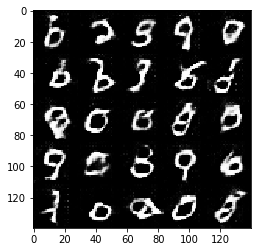

Epoch 2/2... Discriminator Loss: 1.3879... Generator Loss: 0.6611 Step: 2100.0000
Epoch 2/2... Discriminator Loss: 1.3658... Generator Loss: 0.7772 Step: 2200.0000


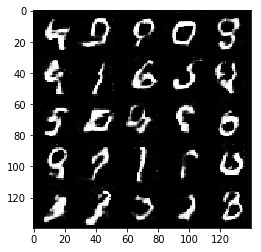

Epoch 2/2... Discriminator Loss: 1.3562... Generator Loss: 0.8626 Step: 2300.0000
Epoch 2/2... Discriminator Loss: 1.3896... Generator Loss: 0.6522 Step: 2400.0000


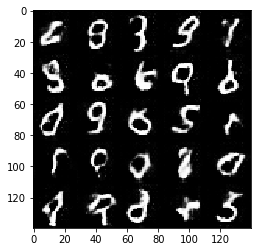

In [13]:
#l_rate = [0.01, 0.005, 0.02]
#b1 = [0.3,0.4,0.5,0.6]

batch_size = 50
z_dim = 50
learning_rate = 0.005
beta1 = 0.4 #4/6

tf.reset_default_graph()
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
20 mins/one epoch

Epoch 1/2... Discriminator Loss: 1.1891... Generator Loss: 1.0581 Step: 100.0000
Epoch 1/2... Discriminator Loss: 1.4692... Generator Loss: 1.0043 Step: 200.0000


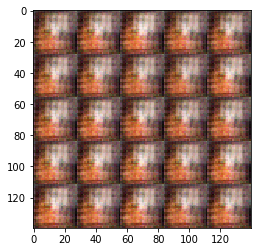

Epoch 1/2... Discriminator Loss: 1.1404... Generator Loss: 0.9399 Step: 300.0000
Epoch 1/2... Discriminator Loss: 1.2003... Generator Loss: 0.9416 Step: 400.0000


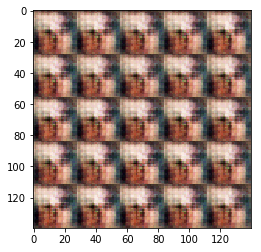

Epoch 1/2... Discriminator Loss: 1.1356... Generator Loss: 0.9740 Step: 500.0000
Epoch 1/2... Discriminator Loss: 1.2661... Generator Loss: 0.8993 Step: 600.0000


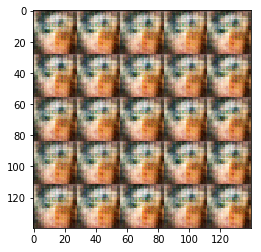

Epoch 1/2... Discriminator Loss: 1.3586... Generator Loss: 0.8857 Step: 700.0000
Epoch 1/2... Discriminator Loss: 1.2265... Generator Loss: 0.8557 Step: 800.0000


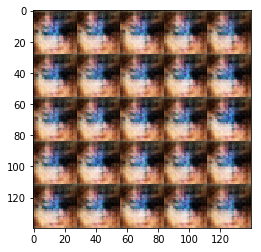

Epoch 1/2... Discriminator Loss: 1.3631... Generator Loss: 0.8282 Step: 900.0000
Epoch 1/2... Discriminator Loss: 1.2244... Generator Loss: 0.9835 Step: 1000.0000


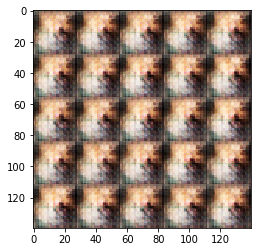

Epoch 1/2... Discriminator Loss: 1.6289... Generator Loss: 1.1557 Step: 1100.0000
Epoch 1/2... Discriminator Loss: 1.1945... Generator Loss: 1.0145 Step: 1200.0000


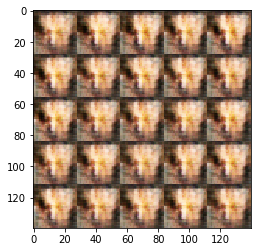

Epoch 1/2... Discriminator Loss: 1.0933... Generator Loss: 1.0061 Step: 1300.0000
Epoch 1/2... Discriminator Loss: 1.1044... Generator Loss: 0.9129 Step: 1400.0000


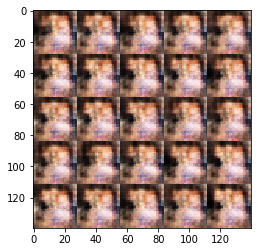

Epoch 1/2... Discriminator Loss: 1.2002... Generator Loss: 0.8294 Step: 1500.0000
Epoch 1/2... Discriminator Loss: 1.2093... Generator Loss: 1.0876 Step: 1600.0000


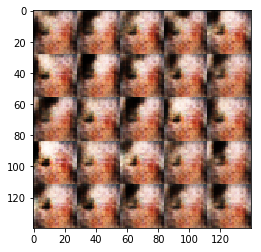

Epoch 1/2... Discriminator Loss: 1.3058... Generator Loss: 0.9748 Step: 1700.0000
Epoch 1/2... Discriminator Loss: 1.3495... Generator Loss: 0.8328 Step: 1800.0000


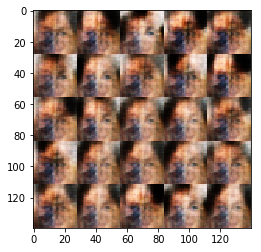

Epoch 1/2... Discriminator Loss: 1.3556... Generator Loss: 0.8926 Step: 1900.0000
Epoch 1/2... Discriminator Loss: 1.4412... Generator Loss: 0.6544 Step: 2000.0000


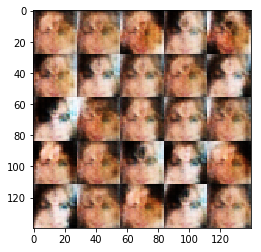

Epoch 1/2... Discriminator Loss: 1.4260... Generator Loss: 0.7463 Step: 2100.0000
Epoch 1/2... Discriminator Loss: 1.4065... Generator Loss: 0.7440 Step: 2200.0000


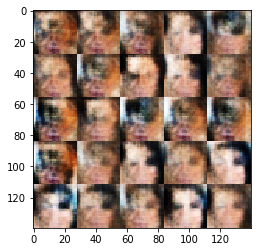

Epoch 1/2... Discriminator Loss: 1.4252... Generator Loss: 0.7212 Step: 2300.0000
Epoch 1/2... Discriminator Loss: 1.4128... Generator Loss: 0.6936 Step: 2400.0000


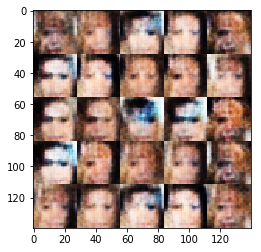

Epoch 1/2... Discriminator Loss: 1.4060... Generator Loss: 0.8132 Step: 2500.0000
Epoch 1/2... Discriminator Loss: 1.4100... Generator Loss: 0.7778 Step: 2600.0000


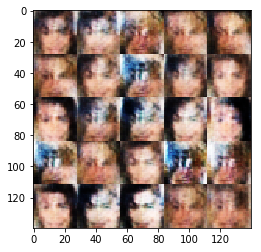

Epoch 1/2... Discriminator Loss: 1.4004... Generator Loss: 0.9294 Step: 2700.0000
Epoch 1/2... Discriminator Loss: 1.4897... Generator Loss: 0.5658 Step: 2800.0000


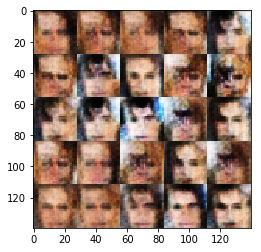

Epoch 1/2... Discriminator Loss: 1.5360... Generator Loss: 1.0706 Step: 2900.0000
Epoch 1/2... Discriminator Loss: 1.4445... Generator Loss: 0.5924 Step: 3000.0000


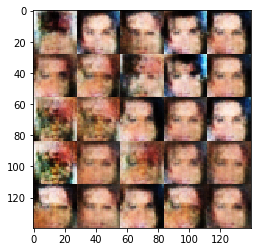

Epoch 1/2... Discriminator Loss: 1.4135... Generator Loss: 0.7342 Step: 3100.0000
Epoch 1/2... Discriminator Loss: 1.4576... Generator Loss: 0.5956 Step: 3200.0000


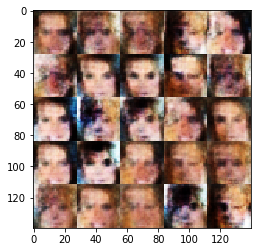

Epoch 1/2... Discriminator Loss: 1.4055... Generator Loss: 0.8568 Step: 3300.0000
Epoch 1/2... Discriminator Loss: 1.4499... Generator Loss: 0.6457 Step: 3400.0000


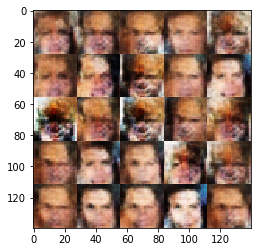

Epoch 1/2... Discriminator Loss: 1.3731... Generator Loss: 0.8315 Step: 3500.0000
Epoch 1/2... Discriminator Loss: 1.3929... Generator Loss: 0.7697 Step: 3600.0000


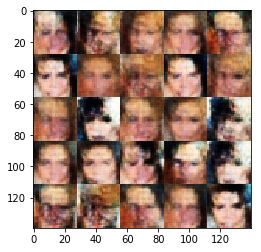

Epoch 1/2... Discriminator Loss: 1.3827... Generator Loss: 0.6667 Step: 3700.0000
Epoch 1/2... Discriminator Loss: 1.4735... Generator Loss: 1.0429 Step: 3800.0000


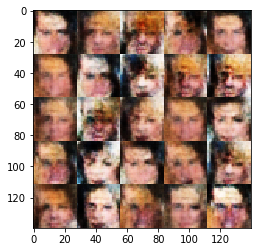

Epoch 1/2... Discriminator Loss: 1.4911... Generator Loss: 0.5199 Step: 3900.0000
Epoch 1/2... Discriminator Loss: 1.3789... Generator Loss: 0.8153 Step: 4000.0000


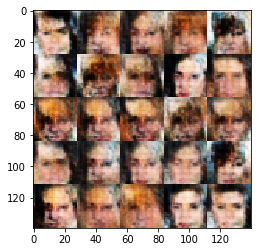

Epoch 1/2... Discriminator Loss: 1.4468... Generator Loss: 1.0171 Step: 4100.0000
Epoch 1/2... Discriminator Loss: 1.4125... Generator Loss: 0.7536 Step: 4200.0000


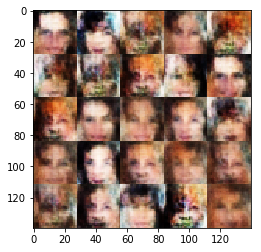

Epoch 1/2... Discriminator Loss: 1.3930... Generator Loss: 0.8948 Step: 4300.0000
Epoch 1/2... Discriminator Loss: 1.4432... Generator Loss: 0.6429 Step: 4400.0000


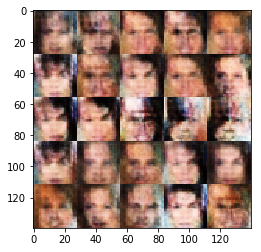

Epoch 1/2... Discriminator Loss: 1.3884... Generator Loss: 0.7781 Step: 4500.0000
Epoch 1/2... Discriminator Loss: 1.3738... Generator Loss: 0.9091 Step: 4600.0000


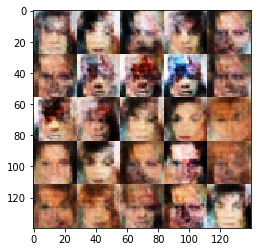

Epoch 1/2... Discriminator Loss: 1.4064... Generator Loss: 0.8122 Step: 4700.0000
Epoch 1/2... Discriminator Loss: 1.3905... Generator Loss: 0.7565 Step: 4800.0000


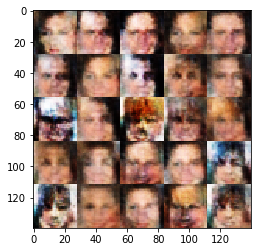

Epoch 1/2... Discriminator Loss: 1.4163... Generator Loss: 0.9545 Step: 4900.0000
Epoch 1/2... Discriminator Loss: 1.3859... Generator Loss: 0.7910 Step: 5000.0000


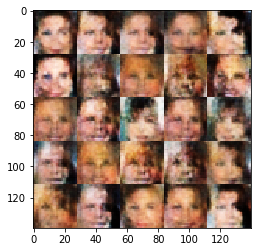

Epoch 1/2... Discriminator Loss: 1.3666... Generator Loss: 0.7592 Step: 5100.0000
Epoch 1/2... Discriminator Loss: 1.4620... Generator Loss: 1.1365 Step: 5200.0000


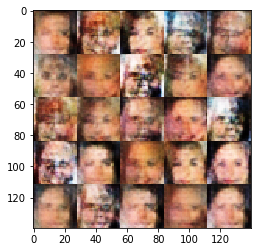

Epoch 1/2... Discriminator Loss: 1.3858... Generator Loss: 0.9072 Step: 5300.0000
Epoch 1/2... Discriminator Loss: 1.4180... Generator Loss: 0.8434 Step: 5400.0000


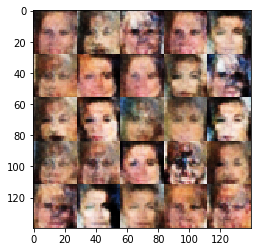

Epoch 1/2... Discriminator Loss: 1.3941... Generator Loss: 0.9017 Step: 5500.0000
Epoch 1/2... Discriminator Loss: 1.4129... Generator Loss: 0.7590 Step: 5600.0000


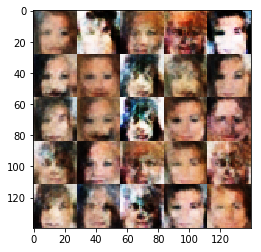

Epoch 1/2... Discriminator Loss: 1.4135... Generator Loss: 0.7475 Step: 5700.0000
Epoch 1/2... Discriminator Loss: 1.3674... Generator Loss: 0.7952 Step: 5800.0000


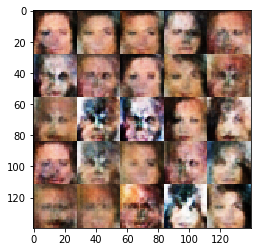

Epoch 1/2... Discriminator Loss: 1.4078... Generator Loss: 0.8871 Step: 5900.0000
Epoch 1/2... Discriminator Loss: 1.4400... Generator Loss: 0.6015 Step: 6000.0000


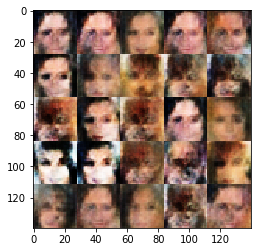

Epoch 1/2... Discriminator Loss: 1.3927... Generator Loss: 0.8851 Step: 6100.0000
Epoch 1/2... Discriminator Loss: 1.3890... Generator Loss: 0.7955 Step: 6200.0000


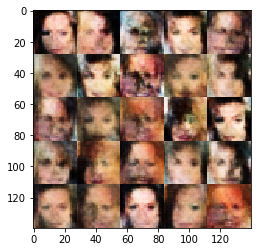

Epoch 1/2... Discriminator Loss: 1.4087... Generator Loss: 0.7062 Step: 6300.0000
Epoch 2/2... Discriminator Loss: 1.4373... Generator Loss: 0.6254 Step: 6400.0000


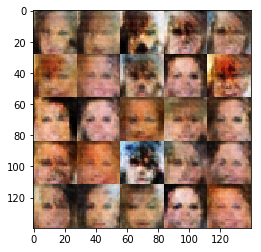

Epoch 2/2... Discriminator Loss: 1.4257... Generator Loss: 0.8105 Step: 6500.0000
Epoch 2/2... Discriminator Loss: 1.4397... Generator Loss: 0.9986 Step: 6600.0000


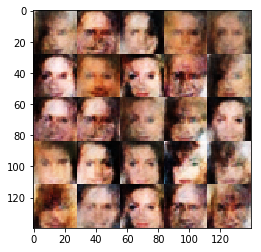

Epoch 2/2... Discriminator Loss: 1.4368... Generator Loss: 0.6331 Step: 6700.0000
Epoch 2/2... Discriminator Loss: 1.4635... Generator Loss: 1.1091 Step: 6800.0000


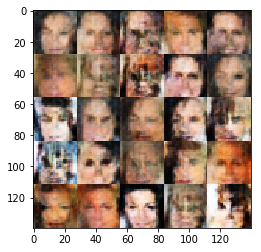

Epoch 2/2... Discriminator Loss: 1.3872... Generator Loss: 0.7061 Step: 6900.0000
Epoch 2/2... Discriminator Loss: 1.4104... Generator Loss: 1.0830 Step: 7000.0000


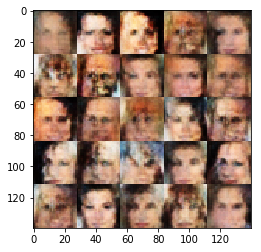

Epoch 2/2... Discriminator Loss: 1.4441... Generator Loss: 0.5984 Step: 7100.0000
Epoch 2/2... Discriminator Loss: 1.3975... Generator Loss: 0.7777 Step: 7200.0000


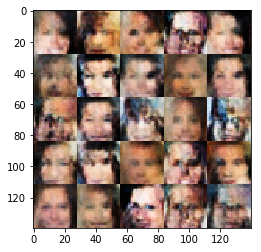

Epoch 2/2... Discriminator Loss: 1.4313... Generator Loss: 0.6843 Step: 7300.0000
Epoch 2/2... Discriminator Loss: 1.4244... Generator Loss: 0.6845 Step: 7400.0000


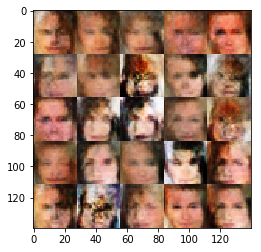

Epoch 2/2... Discriminator Loss: 1.4121... Generator Loss: 0.8477 Step: 7500.0000
Epoch 2/2... Discriminator Loss: 1.4522... Generator Loss: 1.0783 Step: 7600.0000


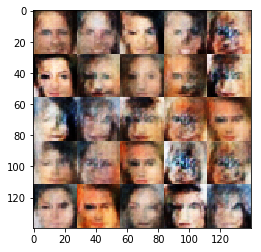

Epoch 2/2... Discriminator Loss: 1.3723... Generator Loss: 0.8594 Step: 7700.0000
Epoch 2/2... Discriminator Loss: 1.4117... Generator Loss: 0.8216 Step: 7800.0000


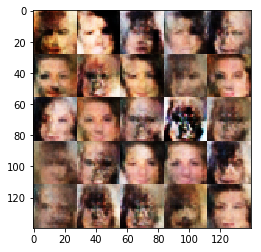

Epoch 2/2... Discriminator Loss: 1.3752... Generator Loss: 0.8138 Step: 7900.0000
Epoch 2/2... Discriminator Loss: 1.4210... Generator Loss: 0.6625 Step: 8000.0000


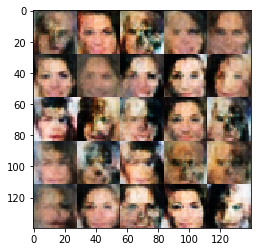

Epoch 2/2... Discriminator Loss: 1.4078... Generator Loss: 0.7107 Step: 8100.0000
Epoch 2/2... Discriminator Loss: 1.4073... Generator Loss: 0.8121 Step: 8200.0000


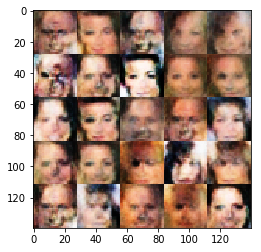

Epoch 2/2... Discriminator Loss: 1.4450... Generator Loss: 0.7327 Step: 8300.0000
Epoch 2/2... Discriminator Loss: 1.4136... Generator Loss: 0.7101 Step: 8400.0000


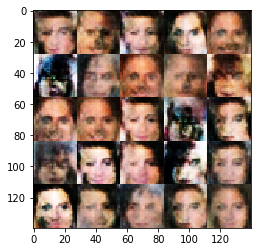

Epoch 2/2... Discriminator Loss: 1.4265... Generator Loss: 1.0111 Step: 8500.0000
Epoch 2/2... Discriminator Loss: 1.4217... Generator Loss: 0.6534 Step: 8600.0000


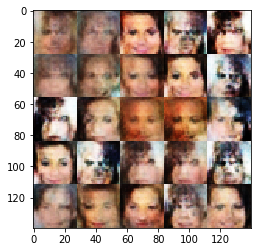

Epoch 2/2... Discriminator Loss: 1.4453... Generator Loss: 0.8168 Step: 8700.0000
Epoch 2/2... Discriminator Loss: 1.3834... Generator Loss: 0.8253 Step: 8800.0000


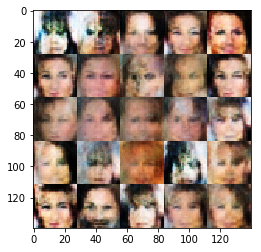

Epoch 2/2... Discriminator Loss: 1.4174... Generator Loss: 0.8113 Step: 8900.0000
Epoch 2/2... Discriminator Loss: 1.3995... Generator Loss: 0.8090 Step: 9000.0000


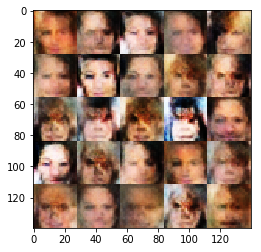

Epoch 2/2... Discriminator Loss: 1.4191... Generator Loss: 0.7437 Step: 9100.0000
Epoch 2/2... Discriminator Loss: 1.4442... Generator Loss: 0.6045 Step: 9200.0000


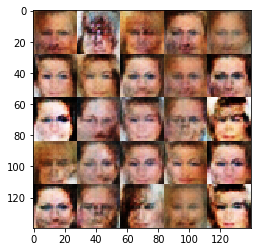

Epoch 2/2... Discriminator Loss: 1.3788... Generator Loss: 0.8102 Step: 9300.0000
Epoch 2/2... Discriminator Loss: 1.3732... Generator Loss: 0.8221 Step: 9400.0000


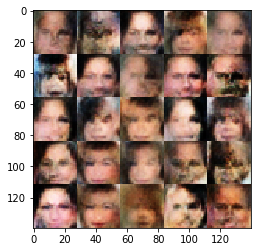

Epoch 2/2... Discriminator Loss: 1.4051... Generator Loss: 0.7671 Step: 9500.0000
Epoch 2/2... Discriminator Loss: 1.4186... Generator Loss: 0.7425 Step: 9600.0000


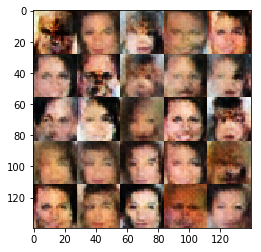

Epoch 2/2... Discriminator Loss: 1.3926... Generator Loss: 0.8547 Step: 9700.0000
Epoch 2/2... Discriminator Loss: 1.3819... Generator Loss: 0.7476 Step: 9800.0000


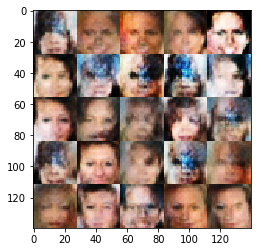

Epoch 2/2... Discriminator Loss: 1.4008... Generator Loss: 0.7693 Step: 9900.0000
Epoch 2/2... Discriminator Loss: 1.4108... Generator Loss: 0.6320 Step: 10000.0000


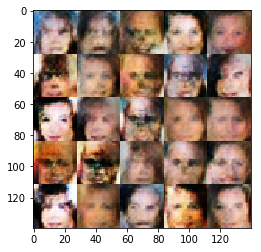

Epoch 2/2... Discriminator Loss: 1.4254... Generator Loss: 0.6056 Step: 10100.0000
Epoch 2/2... Discriminator Loss: 1.4322... Generator Loss: 0.7129 Step: 10200.0000


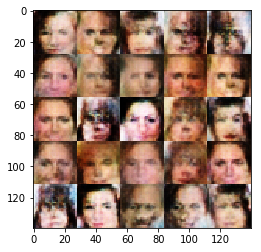

Epoch 2/2... Discriminator Loss: 1.4094... Generator Loss: 0.7129 Step: 10300.0000
Epoch 2/2... Discriminator Loss: 1.3957... Generator Loss: 0.8049 Step: 10400.0000


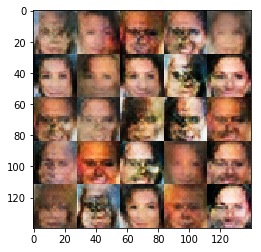

Epoch 2/2... Discriminator Loss: 1.3752... Generator Loss: 0.6937 Step: 10500.0000
Epoch 2/2... Discriminator Loss: 1.3819... Generator Loss: 0.8263 Step: 10600.0000


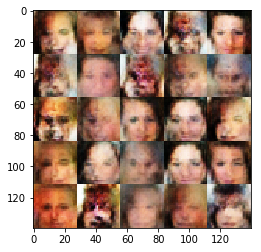

Epoch 2/2... Discriminator Loss: 1.3773... Generator Loss: 0.8574 Step: 10700.0000
Epoch 2/2... Discriminator Loss: 1.4331... Generator Loss: 0.7545 Step: 10800.0000


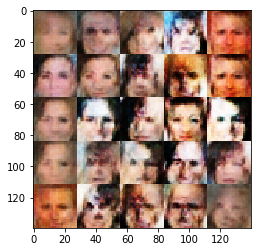

Epoch 2/2... Discriminator Loss: 1.4147... Generator Loss: 0.7593 Step: 10900.0000
Epoch 2/2... Discriminator Loss: 1.4067... Generator Loss: 0.7463 Step: 11000.0000


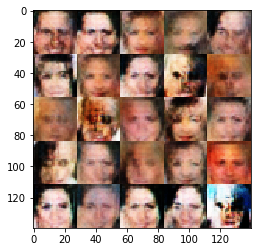

Epoch 2/2... Discriminator Loss: 1.3818... Generator Loss: 0.7795 Step: 11100.0000
Epoch 2/2... Discriminator Loss: 1.4376... Generator Loss: 0.8947 Step: 11200.0000


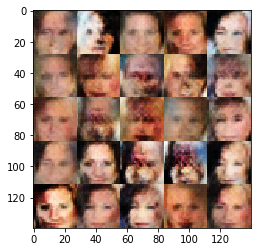

Epoch 2/2... Discriminator Loss: 1.3896... Generator Loss: 0.8805 Step: 11300.0000
Epoch 2/2... Discriminator Loss: 1.3942... Generator Loss: 0.7557 Step: 11400.0000


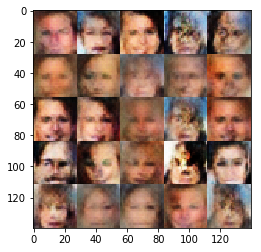

Epoch 2/2... Discriminator Loss: 1.4417... Generator Loss: 0.8165 Step: 11500.0000
Epoch 2/2... Discriminator Loss: 1.3978... Generator Loss: 0.7844 Step: 11600.0000


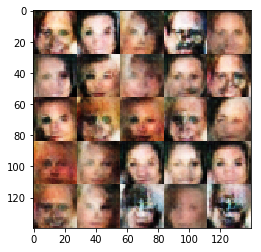

Epoch 2/2... Discriminator Loss: 1.4114... Generator Loss: 0.8657 Step: 11700.0000
Epoch 2/2... Discriminator Loss: 1.3551... Generator Loss: 0.8329 Step: 11800.0000


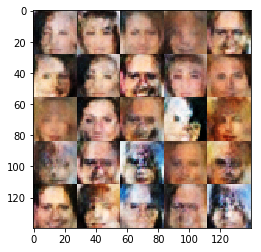

Epoch 2/2... Discriminator Loss: 1.3779... Generator Loss: 0.8616 Step: 11900.0000
Epoch 2/2... Discriminator Loss: 1.3960... Generator Loss: 0.8440 Step: 12000.0000


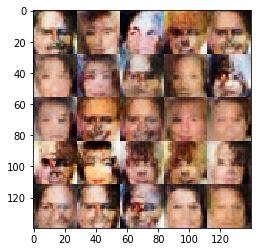

Epoch 2/2... Discriminator Loss: 1.3881... Generator Loss: 0.7537 Step: 12100.0000
Epoch 2/2... Discriminator Loss: 1.3889... Generator Loss: 0.8358 Step: 12200.0000


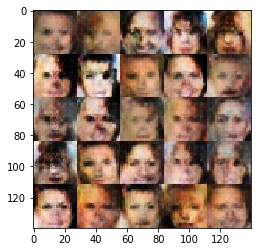

Epoch 2/2... Discriminator Loss: 1.3894... Generator Loss: 0.8246 Step: 12300.0000
Epoch 2/2... Discriminator Loss: 1.4173... Generator Loss: 0.8295 Step: 12400.0000


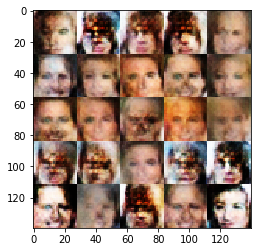

Epoch 2/2... Discriminator Loss: 1.3881... Generator Loss: 0.8987 Step: 12500.0000
Epoch 2/2... Discriminator Loss: 1.4013... Generator Loss: 0.8350 Step: 12600.0000


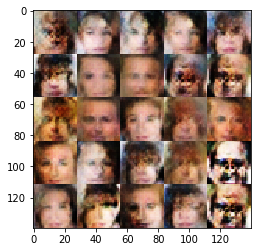

In [14]:
batch_size = 32
z_dim = 128
learning_rate = 0.0003
beta1 = 0.2

epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

# Generated Memes 

Epoch 1/5... Discriminator Loss: 2.4924... Generator Loss: 0.6261 Step: 100.0000
Epoch 1/5... Discriminator Loss: 1.7992... Generator Loss: 0.9015 Step: 200.0000


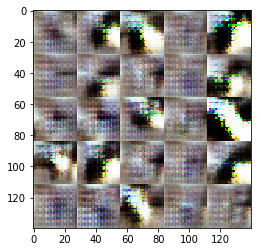

Epoch 1/5... Discriminator Loss: 1.8850... Generator Loss: 0.5953 Step: 300.0000
Epoch 1/5... Discriminator Loss: 1.6360... Generator Loss: 0.7823 Step: 400.0000


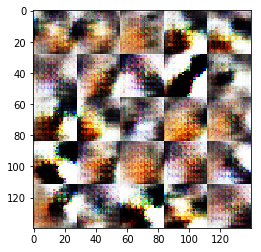

Epoch 1/5... Discriminator Loss: 1.7288... Generator Loss: 0.7264 Step: 500.0000
Epoch 2/5... Discriminator Loss: 1.5973... Generator Loss: 0.6897 Step: 600.0000


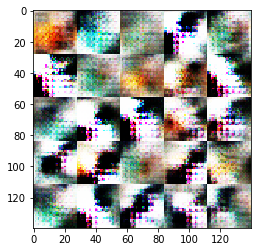

Epoch 2/5... Discriminator Loss: 1.4706... Generator Loss: 0.8128 Step: 700.0000
Epoch 2/5... Discriminator Loss: 1.3765... Generator Loss: 0.7964 Step: 800.0000


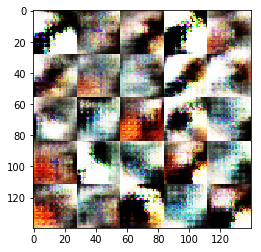

Epoch 2/5... Discriminator Loss: 1.4728... Generator Loss: 0.7980 Step: 900.0000
Epoch 2/5... Discriminator Loss: 1.3933... Generator Loss: 0.7910 Step: 1000.0000


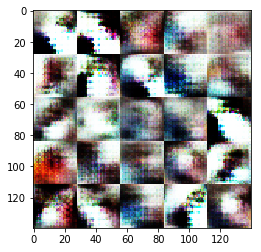

Epoch 2/5... Discriminator Loss: 1.3702... Generator Loss: 0.8013 Step: 1100.0000
Epoch 3/5... Discriminator Loss: 1.3747... Generator Loss: 0.7893 Step: 1200.0000


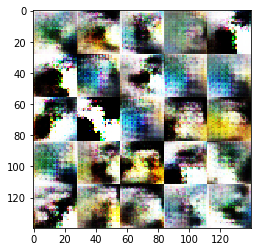

Epoch 3/5... Discriminator Loss: 1.3879... Generator Loss: 0.7984 Step: 1300.0000
Epoch 3/5... Discriminator Loss: 1.4318... Generator Loss: 0.7918 Step: 1400.0000


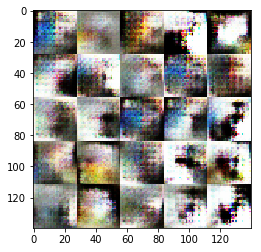

Epoch 3/5... Discriminator Loss: 1.4139... Generator Loss: 0.7574 Step: 1500.0000
Epoch 3/5... Discriminator Loss: 1.3895... Generator Loss: 0.7714 Step: 1600.0000


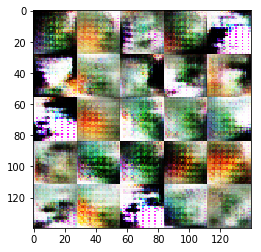

Epoch 3/5... Discriminator Loss: 1.4095... Generator Loss: 0.7784 Step: 1700.0000
Epoch 4/5... Discriminator Loss: 1.3852... Generator Loss: 0.6881 Step: 1800.0000


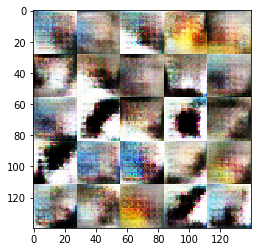

Epoch 4/5... Discriminator Loss: 1.4140... Generator Loss: 0.7150 Step: 1900.0000
Epoch 4/5... Discriminator Loss: 1.4075... Generator Loss: 0.7629 Step: 2000.0000


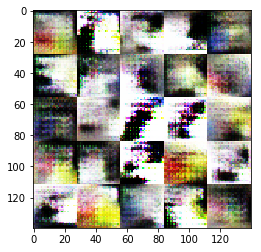

Epoch 4/5... Discriminator Loss: 1.4142... Generator Loss: 0.8324 Step: 2100.0000
Epoch 4/5... Discriminator Loss: 1.4027... Generator Loss: 0.9629 Step: 2200.0000


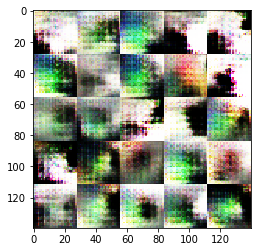

Epoch 4/5... Discriminator Loss: 1.3681... Generator Loss: 0.8120 Step: 2300.0000
Epoch 5/5... Discriminator Loss: 1.4273... Generator Loss: 0.9430 Step: 2400.0000


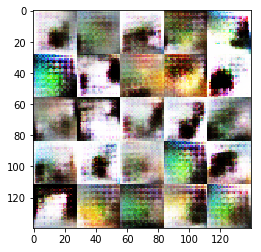

Epoch 5/5... Discriminator Loss: 1.4118... Generator Loss: 0.9493 Step: 2500.0000
Epoch 5/5... Discriminator Loss: 1.4143... Generator Loss: 0.9801 Step: 2600.0000


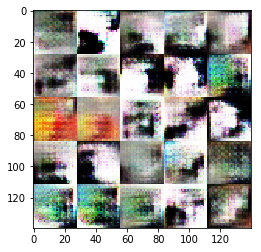

Epoch 5/5... Discriminator Loss: 1.3745... Generator Loss: 0.9509 Step: 2700.0000
Epoch 5/5... Discriminator Loss: 1.3727... Generator Loss: 0.7963 Step: 2800.0000


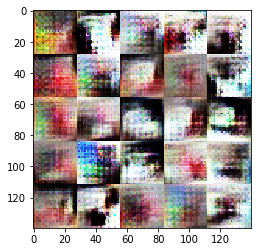

Epoch 5/5... Discriminator Loss: 1.3793... Generator Loss: 0.7829 Step: 2900.0000


In [18]:
batch_size = 32
z_dim = 128
learning_rate = 0.003
beta1 = 0.2
epochs = 5
                  
memes_dataset = helper.Dataset('memes', glob(os.path.join(data_dir, 'memes/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, memes_dataset.get_batches,
          memes_dataset.shape, memes_dataset.image_mode)

### Analysis
The numbers (MNIST) dataset worked the best for the computer in order to generate new similar images due to the similarity of the data. This is similar with the celebrity faces, but with the meme dataset, there was such a wide variety of data and distinct features leading to more abstract images. 